In [0]:
import glob
import yaml
import cv2
import numpy as np
import os
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as im 
import pandas as pd
import seaborn as sns
from skimage.transform import rescale, resize
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread, imshow
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import itertools 

In [0]:
def image_path(img_type, img_number):
    #image_type: 'images' #original image, 'annotations' #crop-weed label, 'mask' #vegetation segmentation
    #image_number: the number on the image name
    image_name = img_type[:-1]
    if img_number < 10:
        path = '/content/'+img_type+'/00'+str(img_number)+'_'+str(image_name)+'.png'
    else:
        path = '/content/'+img_type+'/0'+str(img_number)+'_'+str(image_name)+'.png'
    return path

# generating labels for each image
def label_generator(number):
    annotation = cv2.imread(image_path('annotations', number))
    height = annotation.shape[0]
    width = annotation.shape[1]
   # channel = annotation.shape[2]
    labels = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            if np.all(annotation[i,j,:] == np.array([0,255,0])):
                labels[i,j,0] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,255])):
                labels[i,j,1] = 1
            elif np.all(annotation[i,j,:] == np.array([0,0,0])):
                labels[i,j,2] = 1
    return labels

In [0]:
# Load two images
img1 = cv2.imread(image_path('images',1))
img2 = cv2.imread(image_path('masks',1))

# I want to put logo on top-left corner, So I create a ROI
rows,cols,channels = img2.shape
roi = img1[0:rows, 0:cols ]

# Now create a mask of logo and create its inverse mask also
img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

# Now black-out the area of logo in ROI
img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

# Take only region of logo from logo image.
img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

# Put logo in ROI and modify the main image
dst = cv2.add(img1_bg,img2_fg)
img1[0:rows, 0:cols ] = dst
plt.imshow(img1)

TypeError: ignored

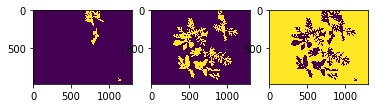

In [0]:
label = label_generator(1)
plt.figure()

#plt.imshow(label)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(label[:,:,i])

In [0]:
levels=[]
train_labels=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_labels:
  label=label_generator(i)
  level=np.sum(label[:,:,1])/(np.sum(label[:,:,1])+np.sum(label[:,:,0]))
  levels.append(level)


In [0]:
for i in range(len(levels)):
  if levels[i] < 0.4 :
    levels[i]=1
  elif (levels[i]>=0.4)&(levels[i]<0.7):
    levels[i]=2
  elif (levels[i]>=0.7)&(levels[i]<0.85):
     levels[i]=3
  else:
     levels[i]=4 

(72576,)
(72576,)


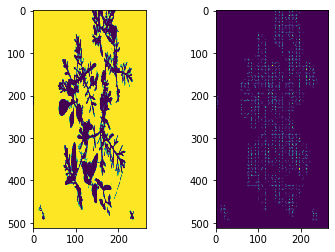

In [0]:
img = imread(image_path('masks',1))
mm = resize(img,(512,265))
fd, hog_image = hog(mm, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=None)
plt.subplot(1,2,1)
plt.imshow(mm)
plt.subplot(1,2,2)
plt.imshow(hog_image)
print(fd.shape)
td = fd.ravel()  
print(td.shape)


(756,)
(756,)


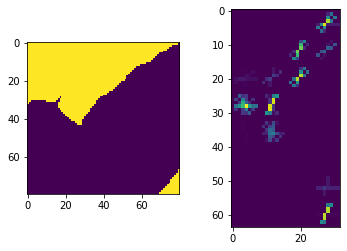

In [0]:
img = imread(image_path('masks',1))
mm = resize(img[640:720,640:720],(64,32))
fd, hog_image = hog(mm, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=None)
plt.subplot(1,2,1)
plt.imshow(img[640:720,640:720])
plt.subplot(1,2,2)
plt.imshow(hog_image)
print(fd.shape)
td = fd.ravel()  
print(td.shape)

In [0]:
img = imread(image_path('masks',1))
width, height = img.shape[:2]
print(width, height )

966 1296


In [0]:
im_feat = []
img = imread(image_path('masks',1))
width, height = img.shape
print(width, height )
for w in range(0, width, 80):
  for h in range(0, height, 80):
      image_resized = resize(img[w:w+80,h:h+80],(80,40))
      descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
      im_feat.append(descriptor)

966 1296


In [0]:
img_feature_train = []

train_data=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_data:
  img_mask = imread(image_path('masks',i))
  img_annt = imread(image_path('annotations',i))
  features_train = []
  for w in range(0, width, 80):
    for h in range(0, height, 80):
      image_resized = resize(img_mask[w:w+80,h:h+80],(40,80))
      descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
      features_train.append(descriptor)
  img_feature_train.append(features_train)
print("younis & menna & Omar")

younis & menna & Omar


In [0]:
print(img_feature_train[0])

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.        , ..., 0.05995835, 0.        ,
       0.        ]), array([0.35800235, 0.06603463, 0.24361082, ..., 0.        , 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.10155805, 0.09292553, 0.4833071 , ..., 0.        , 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
print(len(features_train))
print(len(labels_train))
train_data = []
for i in features_train :
  for j in i:
    train_data.append(j)


8840
8840


In [0]:

features_test = []
labels_test = []
test_data = [1, 3, 4, 9, 10, 13, 15, 21, 22, 26, 29, 30, 32, 35, 39, 44, 47, 48, 54, 60]
for i in test_data:
  img_mask = imread(image_path('masks',i))
  img_annt = imread(image_path('annotations',i))
  for w in range(0, width, 80):
    for h in range(0, height, 80):
      win_img =img_annt[w:w+80,h:h+80]
      x, y = win_img.shape[:2]
      g_count = 0 
      r_count = 0 
      for i in range(x):
        for j in range(y):
          if np.all(win_img[i][j] == np.array([0, 255, 0])):
            g_count+=1
          if np.all(win_img[i][j] == np.array([255, 0, 0])):
            r_count+=1
      if g_count+r_count == 0 :
         labels_test.append(0)
      else:
        win_level = r_count/(g_count+r_count)
        if win_level < 0.4 :
          labels_test.append(1)
        elif (win_level>=0.4)&(win_level<0.7):
          labels_test.append(2)
        elif (win_level>=0.7)&(win_level<0.85):
          labels_test.append(3)
        else:
          labels_test.append(4)

      image_resized = resize(img_mask[w:w+80,h:h+80],(40,80))
      descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
      features_test.append(descriptor)
print("younis & menna & Omar")

younis & menna & Omar


In [0]:
print(features_test)
print(len(features_train))
print(len(labels_test))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
8840
4641


In [0]:

for i in test_labels:
  label=label_generator(i)
  level=np.sum(label[:,:,1])/(np.sum(label[:,:,1])+np.sum(label[:,:,0]))
  levels_test.append(level)
for i in range(len(levels_test)):
  if levels_test[i] < 0.4 :
    levels_test[i]=1
  elif (levels_test[i]>=0.4)&(levels_test[i]<0.7):
    levels_test[i]=2
  elif (levels_test[i]>=0.7)&(levels_test[i]<0.85):
     levels_test[i]=3
  else:
     levels_test[i]=4 

In [0]:
Features_test = []
test_labels = [1, 3, 4, 9, 10, 13, 15, 21, 22, 26, 29, 30, 32, 35, 39, 44, 47, 48, 54, 60]
for i in test_labels:
  img = imread(image_path('masks',i))
  image_resized = resize(img,(512,265))
  descriptor, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), block_norm= 'L2', visualize=True, multichannel=None)
  descriptor.ravel()  # flattened array convert 2D to 1D
  Features_test.append(descriptor)

In [0]:
clf = svm.SVC(class_weight='balanced')
features_train = np.array(features_train)
features_test = np.array(features_test)
labels_test = np.array(labels_test)
labels_train = np.array(labels_train)

In [0]:
clf.fit(features_train,labels_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
labels_pred = clf.predict(features_test)


In [0]:
print("predicted label : "+str(len(labels_pred)))
l1 =0 
l2 =0
l3 =0 
l4 =0
for i in labels_pred :
  if i == 1 :
    l1+=1
  elif i ==2:
    l2+=1
  elif i ==3:
    l3+=1
  elif i ==4:
    l4+=1
print("level 1 : "+str(l1))
print("level 2 : "+str(l2))
print("level 3 : "+str(l3))
print("level 4 : "+str(l4))
print("actual labels : "+str(len(labels_test)))
l1 =0 
l2 =0
l3 =0 
l4 =0
for i in labels_test :
  if i == 1 :
    l1+=1
  elif i ==2:
    l2+=1
  elif i ==3:
    l3+=1
  elif i ==4:
    l4+=1
print("level 1 : "+str(l1))
print("level 2 : "+str(l2))
print("level 3 : "+str(l3))
print("level 4 : "+str(l4))

predicted label : 4641
level 1 : 120
level 2 : 6
level 3 : 2
level 4 : 1102
actual labels : 4641
level 1 : 274
level 2 : 25
level 3 : 10
level 4 : 843


In [0]:
print('MSE: ' , mean_squared_error(labels_test, labels_pred))

MSE:  0.8299935358758889


In [0]:
print(classification_report(labels_test, labels_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3489
           1       0.31      0.14      0.19       274
           2       1.00      0.24      0.39        25
           3       1.00      0.20      0.33        10
           4       0.70      0.92      0.80       843

    accuracy                           0.91      4641
   macro avg       0.80      0.49      0.54      4641
weighted avg       0.91      0.91      0.90      4641



In [0]:
print("Accuracy: "+str(accuracy_score(labels_test, labels_pred)))


Accuracy: 0.9187675070028011


In [0]:
print(len(labels_pred))

4641


In [0]:
import glob
import yaml
import cv2
import numpy as np
import os
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image 
import pandas as pd
import seaborn as sns
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread, imshow
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import itertools 
import imutils 


In [0]:
def image_path(img_type, img_number):
    #image_type: 'images' #original image, 'annotations' #crop-weed label, 'mask' #vegetation segmentation
    #image_number: the number on the image name
    image_name = img_type[:-1]
    if img_number < 10:
        path = '/content/'+img_type+'/00'+str(img_number)+'_'+str(image_name)+'.png'
    else:
        path = '/content/'+img_type+'/0'+str(img_number)+'_'+str(image_name)+'.png'
    return path

In [0]:
def ImageSegmentation(image):
  #convert GRB color to HSV color 
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  sensitivity = 40
  lower_hsv = np.array([60 - sensitivity, 120, 80])
  upper_hsv = np.array([60 + sensitivity, 255, 255])

  # create mask
  mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)

  img_mask = cv2.bitwise_and(image, image, mask = mask)
  
  plt.figure(figsize=(10,10))
  #plt.subplot(5,2,1)
  #plt.imshow(img_mask)

  #applying median filter 
  median_out = cv2.medianBlur(img_mask, 5)
  #plt.subplot(5,2,2)
  #plt.imshow(median_out)

  #Binary Image with threshold
  ret, ImgBW = cv2.threshold(median_out,0,255,cv2.THRESH_BINARY)
  #plt.subplot(5,2,3)
  #plt.imshow(ImgBW)

  #Colorimg  All plante in the image with gray 
  image  = Image.new('RGB',(1296,966),color=(0,255,0))
  Img_out = np.multiply((ImgBW/255),image)
  #plt.subplot(5,2,4)
  #plt.imshow(Img_out)

  #Image Copy 
  Img_Gradient = ImgBW

  #Image Gradient
  kernel = np.ones((3,3),np.uint8)
  for i in range(7):
    Gradient = cv2.morphologyEx(Img_Gradient, cv2.MORPH_GRADIENT, kernel)
    Img_Gradient = Img_Gradient - Gradient
  #plt.subplot(5,2,5)
  #plt.imshow(Img_Gradient)

  #Image Gradient Median Filter :useful pre-processing tool for image segmentation tasks.
  Gradient_median = cv2.medianBlur(Img_Gradient, 7)
  #plt.subplot(5,2,6)
  #plt.imshow(Gradient_median)

  #convert to GRAY Image 
  cnvt_img = cv2.cvtColor(Gradient_median, cv2.COLOR_BGR2GRAY)
  #plt.subplot(5,2,7)
  #plt.imshow(cnvt_img) 
  
  #Convert Gray image to Binary Image (Black & White)
  ret,binary = cv2.threshold(cnvt_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
  #plt.subplot(5,2,8)
 # plt.imshow(binary)
  

  #find contours of remain conncted object 
  contours ,_= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  #Count and Draw Contours 
  contour = []
  max_area = 0
  for cnt in contours :
    area = cv2.contourArea(cnt)
    if area > max_area:
      max_area = area 
    if area > 700:
      if area == max_area: 
        continue
      else:
        contour.append(cnt)
    else:
      continue
  #img_org = cv2.drawContours(image, contour , -1, (255,0,0),thickness =cv2.FILLED)
  img= cv2.drawContours(median_out, contour , -1, (255,0,0),thickness =cv2.FILLED)
  Img_out= cv2.drawContours(Img_out, contour , -1, (255,0,0),thickness =cv2.FILLED)
  return Img_out
 # plt.subplot(5,2,9)
 # plt.imshow(img_org)
  
  #plt.subplot(5,2,10)
  #plt.imshow(Img_out)

In [0]:
train_data=[2, 5, 6, 7, 8, 11, 12, 14, 16, 17, 18, 19, 20, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59]
for i in train_data:
  original_image =cv2.imread(image_path('images',i))
  img_annot=ImageSegmentation(original_image)
  if i < 10:
        plt.imsave('/content/Annotations/'+'00'+str(i)+'_Annotation.png',np.uint8(img_annot))
  else:
        plt.imsave('/content/Annotations/'+'0'+str(i)+'_Annotation.png',np.uint8(img_annot))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
for i in range(60):
  original_image =cv2.imread(image_path('images',i+1))
  img_annot=ImageSegmentation(original_image)
  if i < 10:
        plt.imsave('/content/Annotations/'+'00'+str(i+1)+'_Annotation.png',np.uint8(img_annot))
  else:
        plt.imsave('/content/Annotations/'+'0'+str(i+1)+'_Annotation.png',np.uint8(img_annot))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


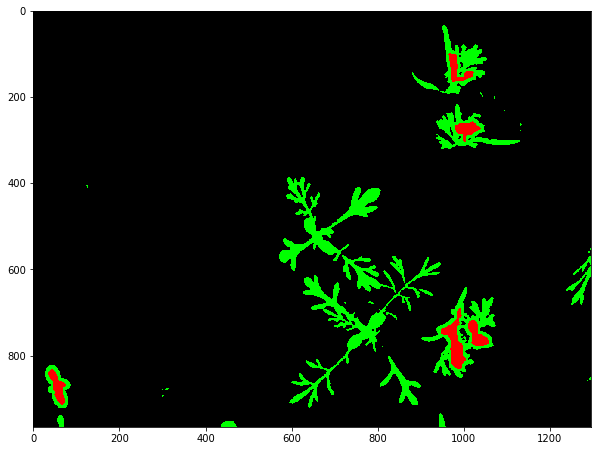

In [0]:
img = ImageSegmentation(img)
plt.imshow(img)